# Classifying Heart Disease

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
heart_data = pd.read_csv('heart_disease.csv')

In [3]:
heart_data.shape

(303, 15)

In [4]:
heart_data.describe()

,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,present
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,152.000000,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.458746
std,87.612784,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.499120
min,1.000000,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,76.500000,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000
50%,152.000000,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,227.500000,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000
max,303.000000,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000


In [5]:
heart_data.rename(columns={'Unnamed: 0': 'patient_id'}, inplace=True)

In [6]:
heart_data.isnull().sum()

patient_id    0
age           0
sex           0
cp            0
trestbps      0
chol          0
fbs           0
restecg       0
thalach       0
exang         0
oldpeak       0
slope         0
ca            0
thal          0
present       0
dtype: int64

In [7]:
heart_data.dtypes

patient_id      int64
age             int64
sex             int64
cp              int64
trestbps        int64
chol            int64
fbs             int64
restecg         int64
thalach         int64
exang           int64
oldpeak       float64
slope           int64
ca             object
thal           object
present         int64
dtype: object

# Data types

From https://archive.ics.uci.edu/dataset/45/heart+disease

| Variable Name | Code   | Role     | Type          | Demographic                | Description                                     | Units   | Missing Values |
|---------------|--------|----------|---------------|----------------------------|-------------------------------------------------|---------|----------------|
| age           | #3     | Feature  | Integer       | Age                        | Age in years                                   | years   | no             |
| sex           | #4     | Feature  | Categorical   | Sex                        | Sex (1 = male; 0 = female)                     |         | no             |
| cp            | #9     | Feature  | Categorical   |                            | Chest pain type: 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic |         | no             |
| trestbps      | #10    | Feature  | Integer       |                            | Resting blood pressure (in mm Hg on admission to the hospital) | mm Hg   | no             |
| chol          | #12    | Feature  | Integer       |                            | Serum cholesterol in mg/dl                     | mg/dl   | no             |
| fbs           | #16    | Feature  | Categorical   |                            | Fasting blood sugar > 120 mg/dl (1 = true; 0 = false) |         | no             |
| restecg       | #19    | Feature  | Categorical   |                            | Resting electrocardiographic results: 0 = normal, 1 = ST-T wave abnormality, 2 = left ventricular hypertrophy |         | no             |
| thalach       | #32    | Feature  | Integer       |                            | Maximum heart rate achieved                    |         | no             |
| exang         | #38    | Feature  | Categorical   |                            | Exercise-induced angina (1 = yes; 0 = no)      |         | no             |
| oldpeak       | #40    | Feature  | Integer       |                            | ST depression induced by exercise relative to rest |         | no             |
| slope         | #41    | Feature  | Categorical   |                            | Slope of the peak exercise ST segment: 1 = upsloping, 2 = flat, 3 = downsloping |         | no             |
| ca            | #44    | Feature  | Integer       |                            | Number of major vessels (0–3) colored by fluoroscopy |         | yes            |
| thal          | #51    | Feature  | Categorical   |                            | Thal: 3 = normal, 6 = fixed defect, 7 = reversible defect |         | yes            |
| num           | #58    | Target   | Integer       |                            | Diagnosis of heart disease (angiographic disease status): 0 = <50% diameter narrowing, 1 = >50% |         | no             |

## Missing data
The source indicates there's some missing data for ca and thal columns. Let's check that

In [8]:
print(heart_data['ca'].unique())
print(heart_data['thal'].unique())
print((heart_data['ca'] == '?').sum())
print((heart_data['thal'] == '?').sum())

['0.0' '3.0' '2.0' '1.0' '?']
['6.0' '3.0' '7.0' '?']
4
2


Only a few missing values, we'll just drop them from the data set and convert the rest to numeric


In [9]:
# Drop rows with '?' values in the heart_data DataFrame
heart_data = heart_data[~heart_data.isin(['?']).any(axis=1)]

In [10]:
# Convert 'ca' and 'thal' columns to numeric
heart_data['ca'] = pd.to_numeric(heart_data['ca'])
heart_data['thal'] = pd.to_numeric(heart_data['thal'])

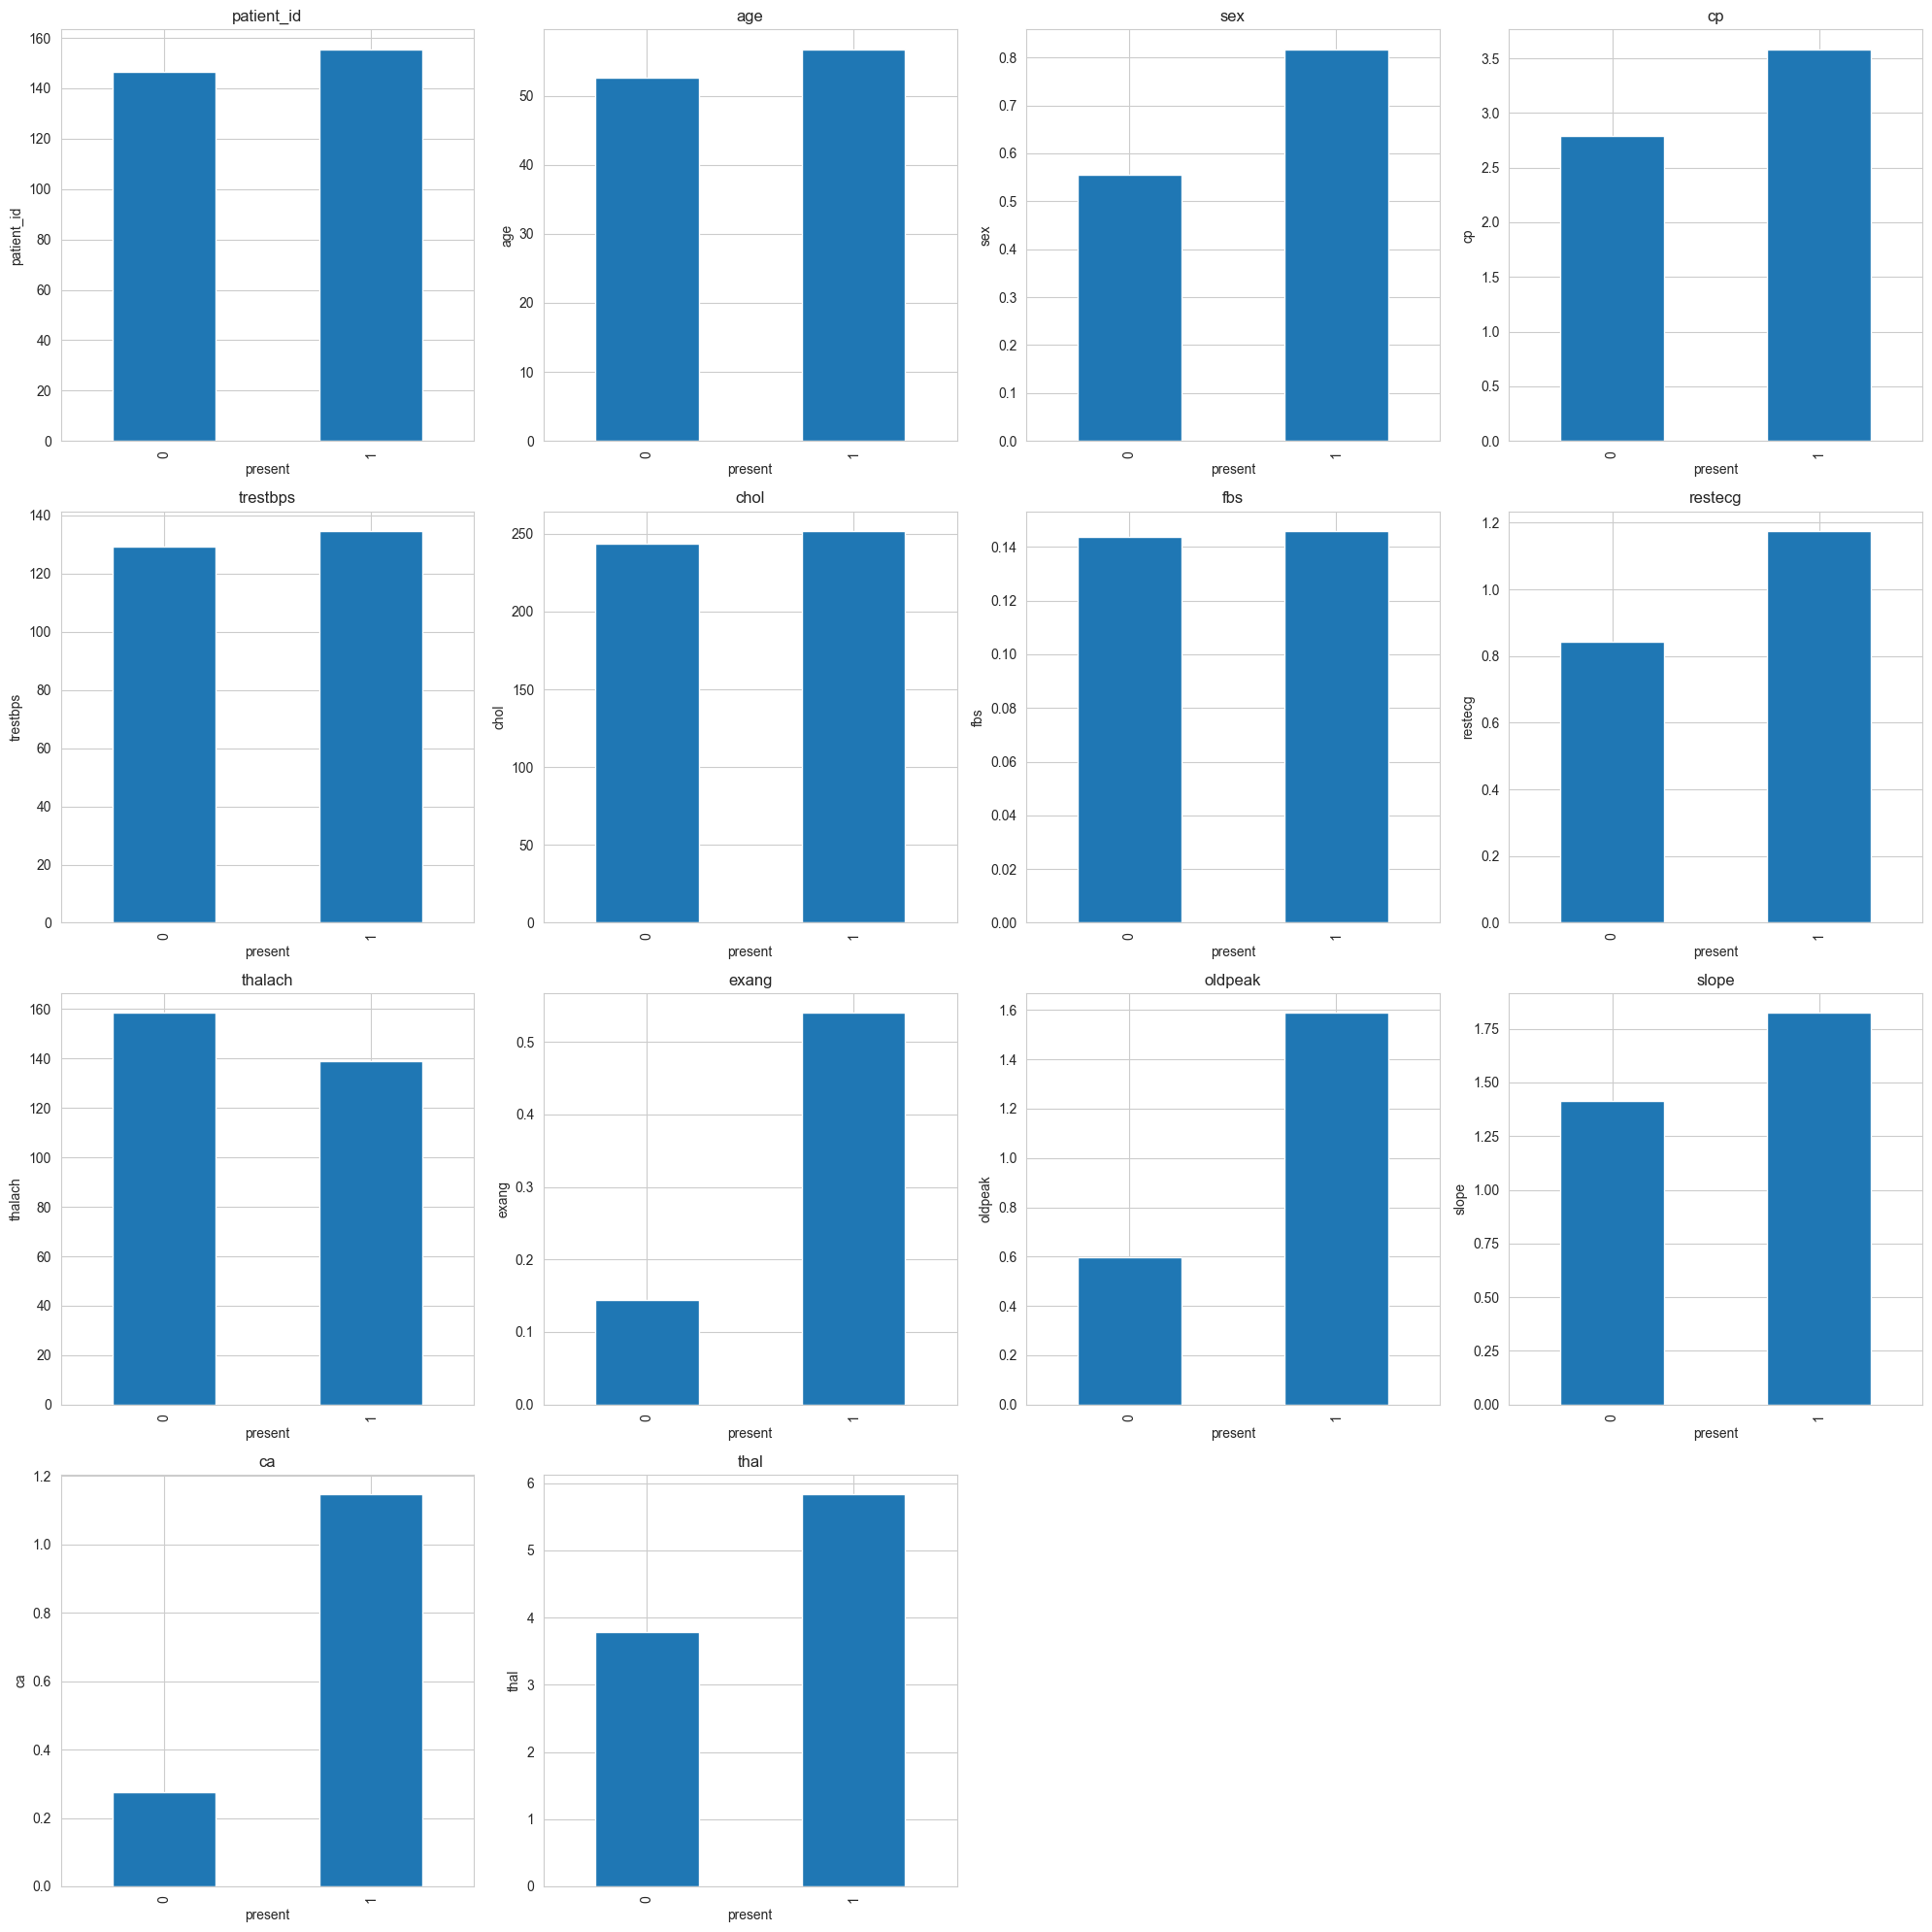

In [11]:
# Plot all features against 'present' column
import matplotlib.pyplot as plt

features = [col for col in heart_data.columns if col != 'present']
num_features = len(features)

fig, axes = plt.subplots(nrows=(num_features + 3) // 4, ncols=4, figsize=(20, 20))
axes = axes.flatten()

for idx, feature in enumerate(features):
    heart_data.groupby('present')[feature].mean().plot(kind='bar', ax=axes[idx])
    axes[idx].set_title(feature)
    axes[idx].set_xlabel('present')
    axes[idx].set_ylabel(feature)

# Hide any unused subplots
for ax in axes[num_features:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

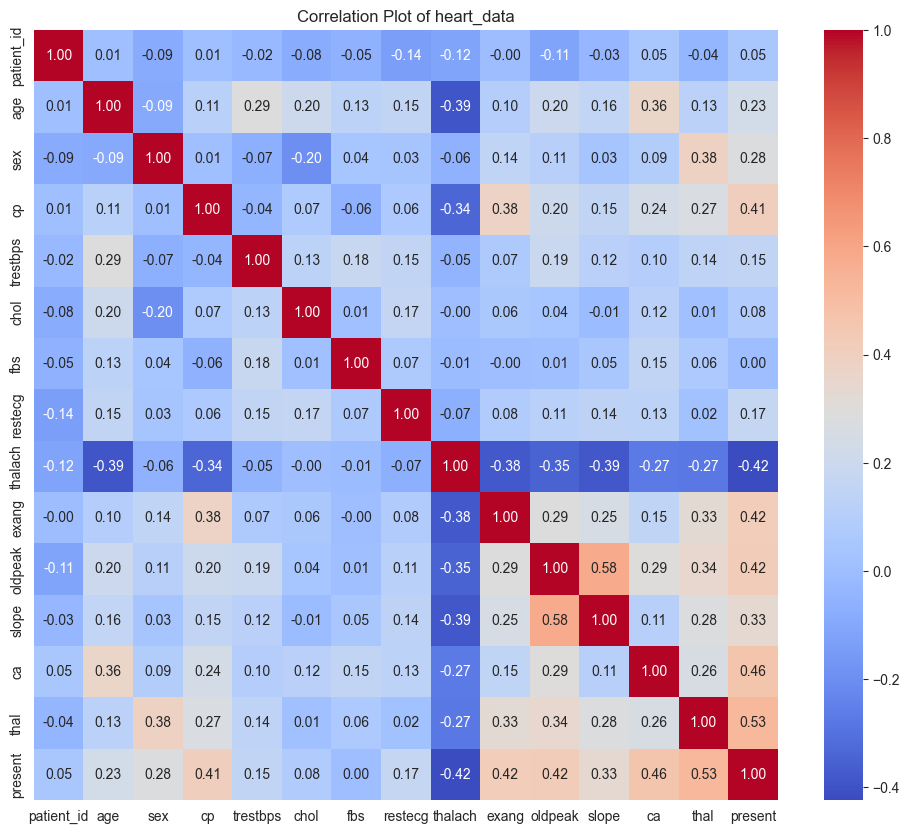

In [12]:
# Generate a correlation plot of the heart_data DataFrame
plt.figure(figsize=(12, 10))
correlation_matrix = heart_data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Plot of heart_data')
plt.show()

In [13]:
correlations_with_present = heart_data.corr()['present'].sort_values(ascending=False)
print(correlations_with_present)

present       1.000000
thal          0.526640
ca            0.463189
oldpeak       0.424052
exang         0.421355
cp            0.408945
slope         0.333049
sex           0.278467
age           0.227075
restecg       0.166343
trestbps      0.153490
chol          0.080285
patient_id    0.051891
fbs           0.003167
thalach      -0.423817
Name: present, dtype: float64


## Data preparation
Based on the correlations, the categorical variables seem to be strong predictors of heart disease, so splitting them out into dummy variables might determine which values are strongly correlated with heart disease

In [14]:
# Create dummy variables for the categorical columns and drop the originals
categorical_columns = ['cp', 'restecg', 'slope', 'thal', 'sex', 'fbs', 'exang']
heart_data = pd.get_dummies(heart_data, columns=categorical_columns, drop_first=False)

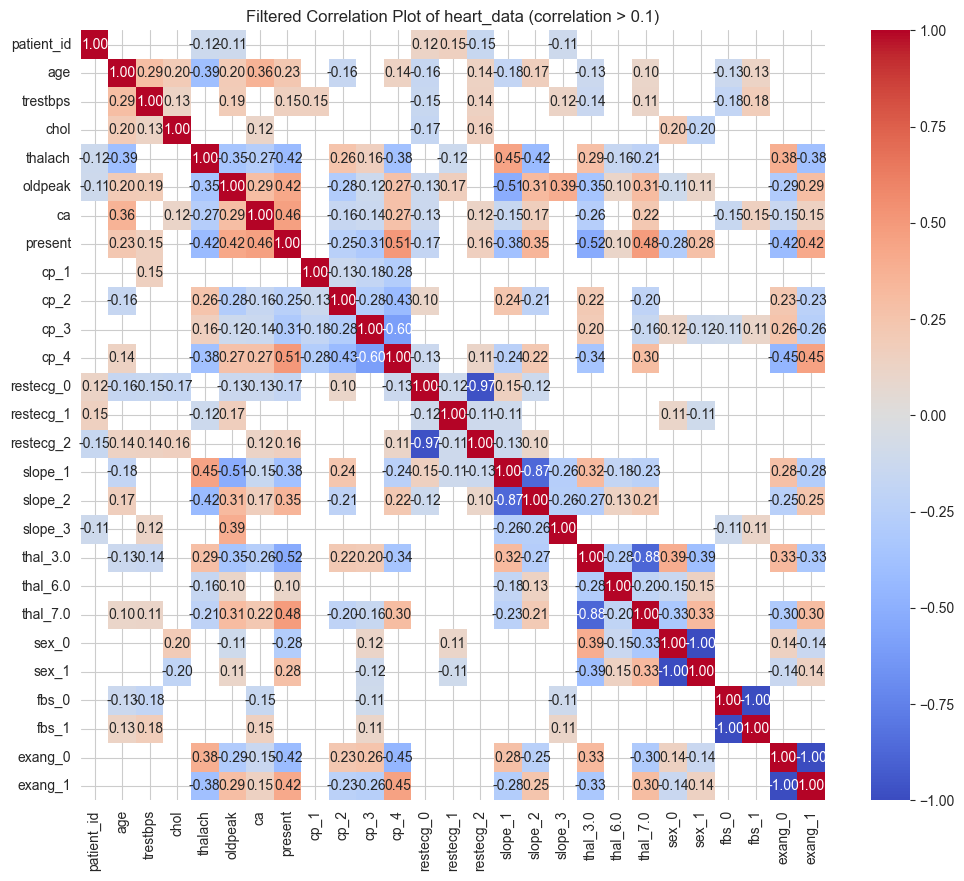

In [21]:
# Calculate the correlations again
plt.figure(figsize=(12, 10))
correlation_matrix = heart_data.corr()

# Filter correlations greater than 0.1
filtered_matrix = correlation_matrix[abs(correlation_matrix) > 0.1]

# Plot the filtered correlation heatmap
sns.heatmap(filtered_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Filtered Correlation Plot of heart_data (correlation > 0.1)')
plt.show()

In [22]:
correlations_with_present = heart_data.corr()['present'].sort_values(ascending=False)
print("Correlation of features with 'present' in descending order:")
print(correlations_with_present)

Correlation of features with 'present' in descending order:
present       1.000000
cp_4          0.507035
thal_7.0      0.484657
ca            0.463189
oldpeak       0.424052
exang_1       0.421355
slope_2       0.349635
sex_1         0.278467
age           0.227075
restecg_2     0.157440
trestbps      0.153490
thal_6.0      0.104651
chol          0.080285
restecg_1     0.067672
slope_3       0.060950
patient_id    0.051891
fbs_1         0.003167
fbs_0        -0.003167
cp_1         -0.091208
restecg_0    -0.173028
cp_2         -0.247535
sex_0        -0.278467
cp_3         -0.305345
slope_1      -0.380612
exang_0      -0.421355
thalach      -0.423817
thal_3.0     -0.524972
Name: present, dtype: float64


In [30]:
# Get the correlations of all features with each other and display the top 20 in descending order
correlation_matrix = heart_data.corr()
correlation_pairs = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)  # Keep only the upper triangle to exclude duplicates
).stack().sort_values(kind="quicksort", ascending=False)  # Flatten and sort

print(correlation_pairs.head(20))

present   cp_4        0.507035
          thal_7.0    0.484657
ca        present     0.463189
cp_4      exang_1     0.454514
thalach   slope_1     0.452458
oldpeak   present     0.424052
present   exang_1     0.421355
oldpeak   slope_3     0.393024
thal_3.0  sex_0       0.390730
thalach   exang_0     0.384368
age       ca          0.362210
present   slope_2     0.349635
thal_7.0  sex_1       0.327671
thal_3.0  exang_0     0.325755
slope_1   thal_3.0    0.315440
oldpeak   slope_2     0.312656
          thal_7.0    0.305253
cp_4      thal_7.0    0.304661
thal_7.0  exang_1     0.301283
oldpeak   ca          0.294452
dtype: float64


## Feature cross correlation
- chest pain and exercise angina being correlated makes sense
- similarly, normal